# Plotting mean and standard deviation of power spectrum over time
All cells except for the last one are used to generate a power spectrum. The last cell plots the power spectrums alongside the mean and standard deviation over all time. This can be used to study cosmic variance in simulations of EoR sky or to observe the correlation between the mean and standard deviation of power values at specific times. The user can generate multiple power spectrums and have them all plotted automatically.

In [1]:
%matplotlib inline
from pyuvdata import UVData
import hera_pspec as hp
import numpy as np
import matplotlib.pyplot as plt
import copy, os, itertools, inspect
from hera_pspec.data import DATA_PATH
import scipy
import matplotlib.gridspec as gridspec

In [2]:
# select the data file to load
dfile_r = os.path.join(DATA_PATH, 'zen.2458116.38650.xx.HH.uvOCRS')
dfile_s = os.path.join(DATA_PATH, 'eorsky_3.00hours_Nside128_sigma0.03_fwhm12.13_uv.uvh5')
# Load into UVData objects
uvd_r = UVData()
uvd_s = UVData()

uvd_r.read(dfile_r)
uvd_s.read(dfile_s)

Telescope eorsky is not in known_telescopes.


NameError: name 'data' is not defined

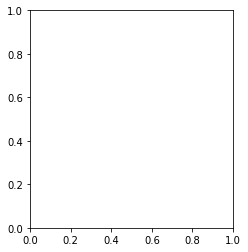

In [3]:
import matplotlib 


# Plot absolute value of visibility
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(np.abs(), aspect='auto', norm=matplotlib.colors.LogNorm(1e0,1e2),
          extent=(hd.freqs[0]/1e6, hd.freqs[-1]/1e6, 
                  hd.lsts[-1]*12/np.pi, hd.lsts[0]*12/np.pi))
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('Amplitude')

# Plot phase of visibility
plt.subplot(122)
plt.imshow(np.angle(data[bl]), aspect='auto',
          extent=(hd.freqs[0]/1e6, hd.freqs[-1]/1e6, 
                  hd.lsts[-1]*12/np.pi, hd.lsts[0]*12/np.pi))
plt.colorbar(label='Visibility Phase')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('Phase')

plt.tight_layout();

In [ ]:
ax[2].hist(v_r.real,bins=30)
ax[2].set_ylabel("Probability Density",fontsize=14)
ax[2].set_xlabel("Visibility Amplitude (Jy)",fontsize=14)

ax[3].hist(v_s.real,bins=30,color='red')
ax[3].set_ylabel("Probability Density",fontsize=14)
ax[3].set_xlabel("Visibility Amplitude (Jy)",fontsize=14)

ax[4].plot(fft_v_r)
ax[4].set_xlabel("Time Index",fontsize=14)
ax[4].set_ylabel("Amplitude",fontsize=14)

ax[5].plot(fft_v_s,color='red')
ax[5].set_xlabel("Time Index",fontsize=14)
ax[5].set_ylabel("Amplitude",fontsize=14)

ax[6].hist(fft_v_r,bins=30)
ax[6].set_xlabel("Amplitude",fontsize=14)
ax[6].set_ylabel("Probability Density",fontsize=14)

ax[7].hist(fft_v_s,bins=30,color='red')
ax[7].set_xlabel("Amplitude",fontsize=14)
ax[7].set_ylabel("Probability Density",fontsize=14)

ax[8].plot(freq_r[xmin_r:xmax_r],v_s[0:102]-v_r,color='blue')
ax[8].set_ylabel("Residuals v_s-v_r (Jy)",fontsize=14)
ax[8].set_xlabel("Frequency (MHz)",fontsize=14)

ax[9].plot(freq_r[xmin_r:xmax_r],fft_v_s[0:102]-fft_v_r,color='green')
ax[9].set_ylabel("Residuals fft_v_s-fft_v_r (Jy)",fontsize=14)
ax[9].set_xlabel("Frequency (MHz)",fontsize=14)

ax[10].hist(v_r-v_s[0:102],bins=30)
ax[10].set_xlabel("Residuals v_s-v_r (Jy)",fontsize=14)
ax[10].set_ylabel("Probability Density",fontsize=14)

ax[11].hist(fft_v_s[0:102]-fft_v_r,color='green')
ax[11].set_xlabel("Residuals fft_v_s-fft_v_r (Jy)",fontsize=14)
ax[11].set_ylabel("Probability Density",fontsize=14)

In [ ]:
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd.freq_array), pol='XX')
# reshape to appropriately match a UVData.data_array object and multiply in!
uvd.data_array *= Jy_to_mK[None, None, :, None]

In [ ]:
# slide the time axis of uvd by one integration
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)

# Create a new PSpecData object, and don't forget to feed the beam object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)
ds.rephase_to_dset(0)
ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

In [ ]:
# Specify which baselines to include
baselines = [(120,121)]
# We can cross multiply different baselines or generate the power spectrum for pairs of identical baselines
baselines1, baselines2, blpairs = hp.utils.construct_blpairs(baselines, exclude_auto_bls=True,exclude_permutations=True)
uvp = ds.pspec(baselines, baselines, (0, 1), [('xx', 'xx')], spw_ranges=[(400,500),(500,600)], input_data_weight='identity',norm='I', taper='blackman-harris', verbose=True)

# This has been commented out but it can be used instead of the previous line
#uvp = ds.pspec(baselines1, baselines2, (0, 1), [('pI', 'pI')], spw_ranges=[(100,200)], input_data_weight='identity',norm='I', taper='blackman-harris', verbose=True)

In [ ]:
# Initialize pwr array containing power data. This is used to plot the histogram below
blpairs = uvp.get_blpairs()
# The figure size will depend approximately on the number of spw ranges and blpairs that were generated.
fig = plt.figure(constrained_layout=False)
fig.set_size_inches(w=18,h=3*len(blpairs)*len(uvp.get_spw_ranges())+2)
gs = gridspec.GridSpec(len(blpairs)*len(uvp.get_spw_ranges()),1)
gs.update(wspace=0.2, hspace=0.5)

# Iterate over all spw ranges and baseline pairs
for i in range(0,len(blpairs)):
    for j in range(0,len(uvp.get_spw_ranges())):
        spw = j
        blp =blpairs[i]
        key = (spw, blp, 'xx')
        dlys = uvp.get_dlys(spw) * 1e9
        
        power = np.abs(np.real(uvp.get_data(key)))
        
        # Time array used for mean and std plot
        time_array = np.linspace(0,power.T.shape[1],power.T.shape[1])

        gss01 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[j+len(uvp.get_spw_ranges())*i],wspace=0.2)

        ax0 = fig.add_subplot(gss01[0])
        ax1 = fig.add_subplot(gss01[1])
        ax_std = ax1.twinx()
        
        ax0.plot(dlys, power.T)
        ax1.plot(time_array, np.mean(power.T,axis=0),alpha=0.7,color='r',ls='--',lw=3,label="Average power")
        ax_std.plot(time_array, np.std(power.T,axis=0),alpha=0.7,color='b',lw=3,label="STD")
        
        # labels and plotting parameters
        ax0.set_yscale('log')
        ax0.grid()
        ax1.grid()
        ax0.set_xlabel("delay [ns]", fontsize=14)
        ax0.set_ylabel(r"$P(k)$", fontsize=14)
        ax1.set_xlabel("Time index", fontsize=14)
        ax1.set_ylabel("Average " + r"$P(k)$", fontsize=14)
        ax_std.set_ylabel(r"$\sigma$", fontsize=14)
        ax0.set_title("spw : {}, blpair : {}, pol : {}".format(*key),fontsize=14)
        ax1.legend()
        ax_std.legend()
